# Surrogate Construction for Genz Functions: BCS

This notebook constructs a PC surrogate for Genz functions with Bayesian Compressive sensing and gives the normalized root mean square error between the surrogate and the actual function. Both the Genz function and PCE are defined on [-1,1].

In [12]:
import numpy as np
import math  
from scipy.stats import qmc
import pandas as pd

import PyUQTk.pce as uqtkpce
import PyUQTk.PyPCE.pce_tools as pce_tools
from PyUQTk.utils.func import *

import matplotlib.pyplot as plt

We define our input parameters. BCS is best for undetermined models and/or large basis sets.

In [6]:
# PC parameters
nord = 4            # Order of the final PCE basis
ndim = 4            # Number of dimensions
pc_type = "LU"      # Polynomial type
pc_alpha = 0.0      # Free parameter > -1 for Gamma-Laguerre and Beta-Jacobi PCs
pc_beta = 1.0       # Free parameter > -1 for Gamma-Laguerre and Beta-Jacobi PCs

# Model to represent
model = 'genz_osc'   # Choices are 'genz_osc', 'genz_exp', 'genz_cont','genz_gaus','genz_cpeak', 'genz_ppeak'

We randomly generate training and testing data with added noise.

In [7]:
# PC model with a full basis set
pc_model =  uqtkpce.PCSet("NISPnoq", nord, ndim, pc_type, pc_alpha, pc_beta)

# Random number generator
rng = qmc.LatinHypercube(d=ndim, seed=43)

#Training
np.random.seed(42)
nTrain = int(pc_model.GetNumberPCTerms()*1) # Number of training samples
x_tr_no_noise = 2*rng.random(n=nTrain)-1
x_train = x_tr_no_noise + np.random.normal(0, 0.1, size = x_tr_no_noise.shape)
y_train = func(x_tr_no_noise, model, np.ones(ndim+1))

#Testing
nTest = 10000  # Number of testing samples
x_test_no_noise = 2*rng.random(n=nTest)-1
x_test = x_test_no_noise + np.random.normal(0, 0.1, size = x_test_no_noise.shape)
y_test = func(x_test_no_noise, model, np.ones(ndim+1))

## BCS with default settings

We perform BCS by inputting the PCSet object that contains the starting basis, the x training data, and the y training data. 

Set verbose to:
* 0 to silence print statements, 
* 1 for some statements, 
* 2 for all statements. 

UQTkBCS returns pc_final, a PCSet object that contains the set of basis terms selected by BCS, and c_k, an array of coefficients.

We then evaluate the polynomial chaos expansion and calculate the normalized root mean square error.

============  Split # 1 / 1 ============
==== BCS with multiindex of size 70 ====
BCS has selected 17 basis terms out of 70
Coefficients:
[-0.40426661 -0.39440045 -0.38787995 -0.38299555 -0.36322194  0.20481367
  0.17744271  0.17615609  0.16997361  0.16081588  0.101805    0.10113724
  0.09661748 -0.07820574 -0.06027544  0.05970374  0.03663573]
17  terms retained out of a full basis of size 70
Reestimated sigma2: 5.758e-03

The NRMS error between a 4-dimensional genz_osc function and a BCS-based PC surrogate of order 4 is 3.986e-01


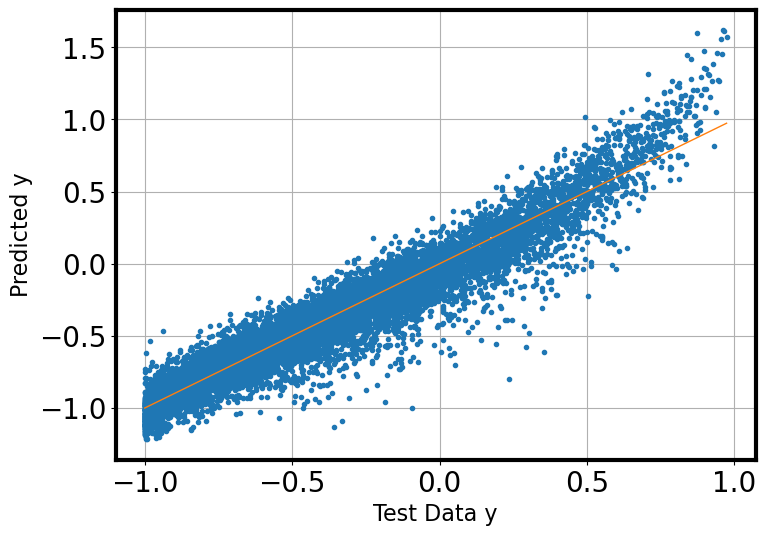

In [20]:
# Define PC object
pc_start = uqtkpce.PCSet("NISPnoq", nord, ndim, pc_type, pc_alpha, pc_beta)

# Perform BCS
pc_final, c_k, _ = pce_tools.UQTkBCS(pc_start, x_train, y_train, verbose=1, return_sigma2=True)

# Evaluate the PCE on test data
pce_evals = pce_tools.UQTkEvaluatePCE(pc_final, c_k, x_test)

# Calculate error metric
MSE = np.square(np.subtract(y_test, pce_evals)).mean()
NRMSE=math.sqrt(MSE)/np.abs(y_test.mean())

print("\nThe NRMS error between a %d-dimensional %s function and a BCS-based PC surrogate of \
order %d is %.3e"%(ndim,model,nord,NRMSE))

# Plot the PCE evaluation on test data vs. the actual test data using a parity plot
fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.add_axes([0.15, 0.15, 0.80, 0.75])

y_test_mM = [y_test.min(),y_test.max()]

ax1.plot(y_test,pce_evals,".")
ax1.plot(y_test_mM,y_test_mM) # Diagonal line

ax1.set_xlabel("Test Data y", size=16)
ax1.set_ylabel("Predicted y", size=16); 


## Data noise specification
We have the option to specify the amount of noise variance we assume is in the data. By default, sigma2 = 1e-8, however, this can be adapted based on the knowledge we have of our data.

In this example, we added noise with a standard deviation of 0.1, so can specify sigma2 = 0.01 to improve accuracy.

BCS reestimates the noise variance in the data and will return it if return_sigma2 = True.

============  Split # 1 / 1 ============
==== BCS with multiindex of size 70 ====
BCS has selected 8 basis terms out of 70
Coefficients:
[-0.41699246 -0.41728052 -0.3752697  -0.37492286 -0.35607029  0.10600481
  0.07808621  0.0588526 ]
8  terms retained out of a full basis of size 70
Reestimated sigma2: 1.027e-02

The NRMS error between a 4-dimensional genz_osc function and a BCS-based PC surrogate of order 4 is 3.413e-01


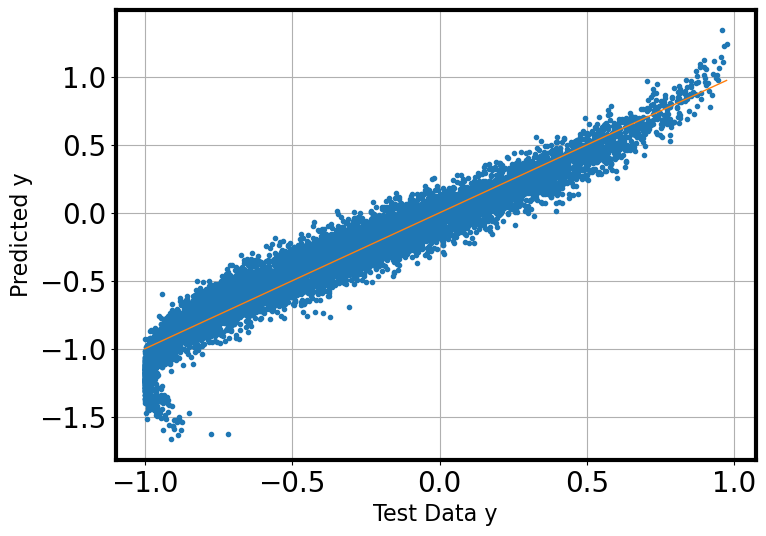

In [22]:
# Define PC object
pc_start = uqtkpce.PCSet("NISPnoq", nord, ndim, pc_type, pc_alpha, pc_beta)

# Perform BCS
pc_final, c_k, sigma2_reestimated = pce_tools.UQTkBCS(pc_start, x_train, y_train, sigma2=0.01, return_sigma2=True, verbose=1)

# Evaluate the PCE
pce_evals = pce_tools.UQTkEvaluatePCE(pc_final, c_k, x_test)

# Calculate error metric
MSE = np.square(np.subtract(y_test, pce_evals)).mean()
NRMSE=math.sqrt(MSE)/np.abs(y_test.mean())

print("\nThe NRMS error between a %d-dimensional %s function and a BCS-based PC surrogate of \
order %d is %.3e"%(ndim,model,nord,NRMSE))

# Plot the PCE evaluation on test data vs. the actual test data using a parity plot
fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.add_axes([0.15, 0.15, 0.80, 0.75])

y_test_mM = [y_test.min(),y_test.max()]

ax1.plot(y_test,pce_evals,".")
ax1.plot(y_test_mM,y_test_mM) # Diagonal line

ax1.set_xlabel("Test Data y", size=16)
ax1.set_ylabel("Predicted y", size=16); 

## Basis cross-validation
 To ensure important basis terms are selected, we may also perform BCS on multiple splits of the training data. BCS selects basis terms in each split, then the intersection of the basis terms is found, and regression is run on that set of intersecting basis terms. The default setting is ntry = 1. Here, we show ntry = 2.

In [23]:
# Define PC object
pc_start = uqtkpce.PCSet("NISPnoq", nord, ndim, pc_type, pc_alpha, pc_beta)

# Perform BCS
pc_final, c_k = pce_tools.UQTkBCS(pc_start, x_train, y_train, ntry=2, verbose=1)

# Evaluate the PCE
pce_evals = pce_tools.UQTkEvaluatePCE(pc_final, c_k, x_test)

# Calculate error metric
MSE = np.square(np.subtract(y_test, pce_evals)).mean()
NRMSE=math.sqrt(MSE)/np.abs(y_test.mean())
print("The NRMS error between a", ndim, "-dimensional", model, "function and a BCS-based PC surrogate of \
order", nord, "is")
NRMSE

============  Split # 1 / 2 ============
==== BCS with multiindex of size 70 ====
BCS has selected 6 basis terms out of 70
============  Split # 2 / 2 ============
==== BCS with multiindex of size 70 ====
BCS has selected 9 basis terms out of 70
Coefficients:
[-0.36159581 -0.4003449  -0.42695139 -0.36334667 -0.42364005]
5  terms retained out of a full basis of size 70
Reestimated sigma2: 7.943e-03

Please note that sigma2 will be returned by default in future versions.
To remain compatible, set input argument return_sigma2 to True and expect
three return arguments: pc_model, coefficients, updated noise variance

The NRMS error between a 4 -dimensional genz_osc function and a BCS-based PC surrogate of order 4 is


0.3662391313936095

## Basis growth
We may also perform BCS with iterations of basis growth. We give BCS a basis of a smaller starting order, then grow the basis in the areas that are most advantageous. This allows us to calculate higher order PCEs without the computational cost of computing a full basis set of coefficients. The default is mindex_growth = None and the niter (number of iterations) = 1.

Here we show 2 iterations of nonconservative basis growth, which adds multiindex entries of a higher order if *any* of the parents are in the current set.  

In [24]:
niter=2

# Define PC object
start_ord = nord-niter+1 # if basis growth, shrink starting basis to allow for growth niter-1 times  
pc_start = uqtkpce.PCSet("NISPnoq", start_ord, ndim, pc_type, pc_alpha, pc_beta)

# Perform BCS
pc_final, c_k = pce_tools.UQTkBCS(pc_start, x_train, y_train, niter=niter, mindex_growth='nonconservative', verbose=1)

# Evaluate the PCE
pce_evals = pce_tools.UQTkEvaluatePCE(pc_final, c_k, x_test)

# Calculate error metric
MSE = np.square(np.subtract(y_test, pce_evals)).mean()
NRMSE=math.sqrt(MSE)/np.abs(y_test.mean())
print("The NRMS error between a", ndim, "-dimensional", model, "function and a BCS-based PC surrogate of \
order", nord, "is")
NRMSE

============  Split # 1 / 1 ============
==== BCS with multiindex of size 35 ====
BCS has selected 14 basis terms out of 35
==== BCS with multiindex of size 49 ====
BCS has selected 8 basis terms out of 49
Coefficients:
[-0.42936009 -0.41619203 -0.38638634 -0.38245578 -0.35561764  0.10454476
  0.1129687   0.07118968]
8  terms retained out of a full basis of size 70
Reestimated sigma2: 1.018e-02

Please note that sigma2 will be returned by default in future versions.
To remain compatible, set input argument return_sigma2 to True and expect
three return arguments: pc_model, coefficients, updated noise variance

The NRMS error between a 4 -dimensional genz_osc function and a BCS-based PC surrogate of order 4 is


0.3629652828458754

We can also use conservative basis growth, which adds multiindex entries of a higher order if *all* parents are in the current set.

In [25]:
# Perform BCS
pc_final, c_k = pce_tools.UQTkBCS(pc_start, x_train, y_train, niter=niter, mindex_growth='conservative', verbose=1)

# Evaluate the PCE
pce_evals = pce_tools.UQTkEvaluatePCE(pc_final, c_k, x_test)

# Calculate error metric
MSE = np.square(np.subtract(y_test, pce_evals)).mean()
NRMSE=math.sqrt(MSE)/np.abs(y_test.mean())
print("The NRMS error between a", ndim, "-dimensional", model, "function and a BCS-based PC surrogate of \
order", nord, "is")
NRMSE

============  Split # 1 / 1 ============
==== BCS with multiindex of size 35 ====
BCS has selected 14 basis terms out of 35
==== BCS with multiindex of size 23 ====
BCS has selected 8 basis terms out of 23
Coefficients:
[-0.42936009 -0.41619203 -0.38638634 -0.38245578 -0.35561764  0.10454476
  0.1129687   0.07118968]
8  terms retained out of a full basis of size 70
Reestimated sigma2: 1.018e-02

Please note that sigma2 will be returned by default in future versions.
To remain compatible, set input argument return_sigma2 to True and expect
three return arguments: pc_model, coefficients, updated noise variance

The NRMS error between a 4 -dimensional genz_osc function and a BCS-based PC surrogate of order 4 is


0.3629652828458754

## Eta optimization

BCS uses the stopping threshold, eta, to determine how many coefficients to retain in the final basis. Larger etas stop the algorithm sooner, causing BCS to retain fewer terms. The default eta is 1e-3. 

If eta is given an array or list as an argument, the optimum value is chosen through cross-validation on a specified number of folds (eta_folds). If eta_plot = True, a plot of the cross-validation results is generated.

The optimal eta is selected according to the following process:
- Split training into folds (according to eta_folds)
- For each fold:
    -  For each eta in the list, 
        - Perform BCS
        - Compute RMSE for training and testing
- Average the training and testing errors over the folds
- Return the eta with the lowest average RMSE


For large values of eta, the training and testing error should increase as the surrogate approximation becomes less precise.
Meanwhile, small values of eta can lead to overfitting, increasing the testing error.


This example performs eta-optimizing BCS with 2 iterations of nonconservative basis growth. We will use factors of 10 between 1e-16 and 1 for possible etas and 10 folds for cross-validation.


Please note that sigma2 will be returned by default in future versions.
To remain compatible, set input argument return_sigma2 to True and expect
three return arguments: pc_model, coefficients, updated noise variance


Please note that sigma2 will be returned by default in future versions.
To remain compatible, set input argument return_sigma2 to True and expect
three return arguments: pc_model, coefficients, updated noise variance


Please note that sigma2 will be returned by default in future versions.
To remain compatible, set input argument return_sigma2 to True and expect
three return arguments: pc_model, coefficients, updated noise variance


Please note that sigma2 will be returned by default in future versions.
To remain compatible, set input argument return_sigma2 to True and expect
three return arguments: pc_model, coefficients, updated noise variance


Please note that sigma2 will be returned by default in future versions.
To remain compatible, set input argument return_sig

0.3524436425793535

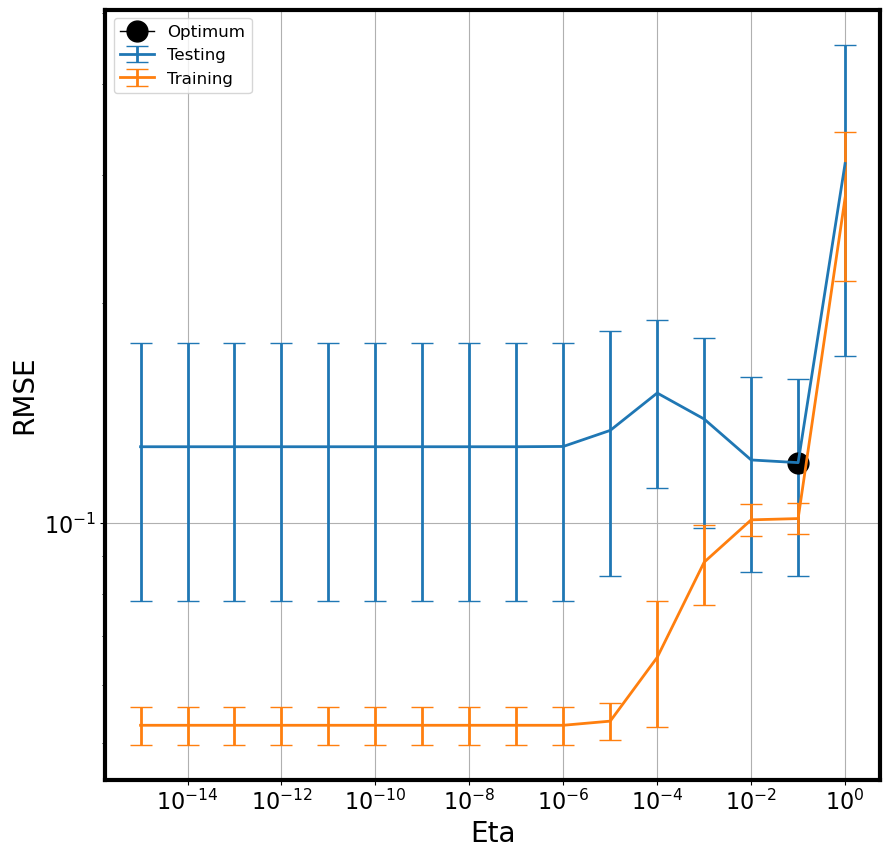

In [26]:
# create an array of possible etas: [1e-16, 1e-15, ... , 1e-2, 1e-1, 1]
eta = 1/np.power(10,[i for i in range(0,16)])

# Perform BCS
pc_final, c_k = pce_tools.UQTkBCS(pc_start, x_train, y_train, niter=niter, mindex_growth='nonconservative', eta=eta, eta_folds=10, eta_plot=True)

# Evaluate the PCE
pce_evals = pce_tools.UQTkEvaluatePCE(pc_final, c_k, x_test)

# Calculate error metric
MSE = np.square(np.subtract(y_test, pce_evals)).mean()
NRMSE=math.sqrt(MSE)/np.abs(y_test.mean())
print("The NRMS error between a", ndim, "-dimensional", model, "function and a BCS-based PC surrogate of \
order", nord, "is")
NRMSE

We can also use more folds for eta cross-validation. This decreases the bias but increases variance and computational cost. Here, we use 20 folds.


Please note that sigma2 will be returned by default in future versions.
To remain compatible, set input argument return_sigma2 to True and expect
three return arguments: pc_model, coefficients, updated noise variance


Please note that sigma2 will be returned by default in future versions.
To remain compatible, set input argument return_sigma2 to True and expect
three return arguments: pc_model, coefficients, updated noise variance


Please note that sigma2 will be returned by default in future versions.
To remain compatible, set input argument return_sigma2 to True and expect
three return arguments: pc_model, coefficients, updated noise variance


Please note that sigma2 will be returned by default in future versions.
To remain compatible, set input argument return_sigma2 to True and expect
three return arguments: pc_model, coefficients, updated noise variance


Please note that sigma2 will be returned by default in future versions.
To remain compatible, set input argument return_sig

0.38122349530365623

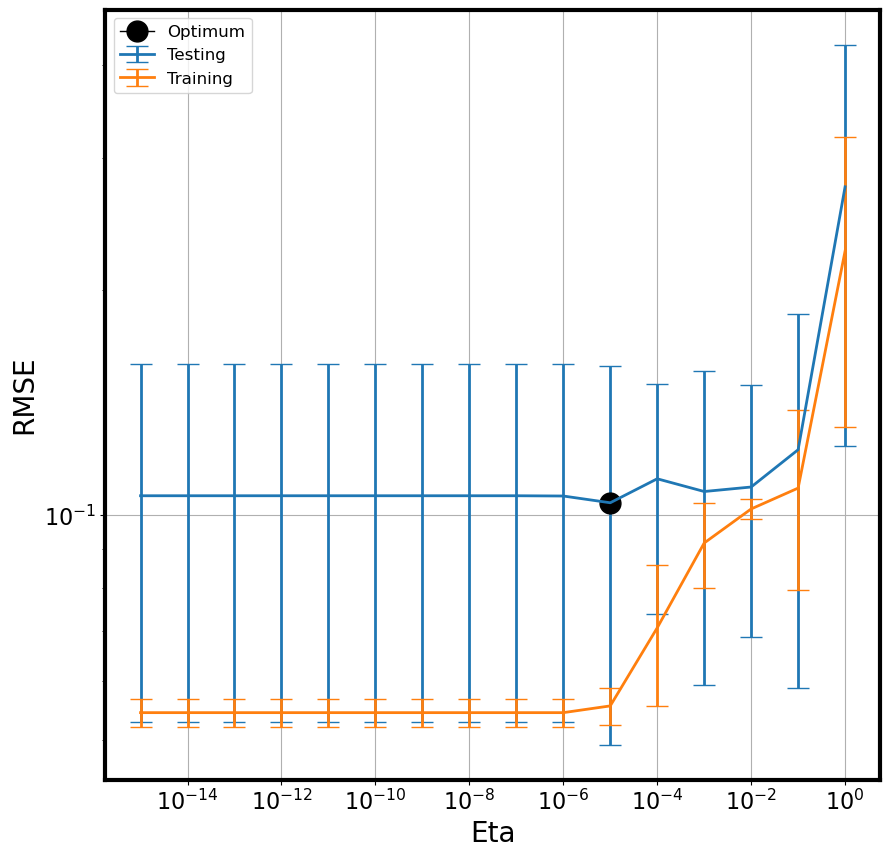

In [27]:
# Perform BCS
pc_final, c_k = pce_tools.UQTkBCS(pc_start, x_train, y_train, niter=niter, mindex_growth='nonconservative', eta=eta, eta_folds=20, eta_plot=True)

# Evaluate the PCE
pce_evals = pce_tools.UQTkEvaluatePCE(pc_final, c_k, x_test)

# Calculate error metric
MSE = np.square(np.subtract(y_test, pce_evals)).mean()
NRMSE=math.sqrt(MSE)/np.abs(y_test.mean())
print("The NRMS error between a", ndim, "-dimensional", model, "function and a BCS-based PC surrogate of \
order", nord, "is")
NRMSE

If BCS is set to grow the basis, eta cross-validation does not implement basis growth by default. However, if eta_growth = True, the selection for optimum eta will take basis growth into account. This increases both computational time and precision.


Please note that sigma2 will be returned by default in future versions.
To remain compatible, set input argument return_sigma2 to True and expect
three return arguments: pc_model, coefficients, updated noise variance


Please note that sigma2 will be returned by default in future versions.
To remain compatible, set input argument return_sigma2 to True and expect
three return arguments: pc_model, coefficients, updated noise variance


Please note that sigma2 will be returned by default in future versions.
To remain compatible, set input argument return_sigma2 to True and expect
three return arguments: pc_model, coefficients, updated noise variance


Please note that sigma2 will be returned by default in future versions.
To remain compatible, set input argument return_sigma2 to True and expect
three return arguments: pc_model, coefficients, updated noise variance


Please note that sigma2 will be returned by default in future versions.
To remain compatible, set input argument return_sig

0.3524436425793535

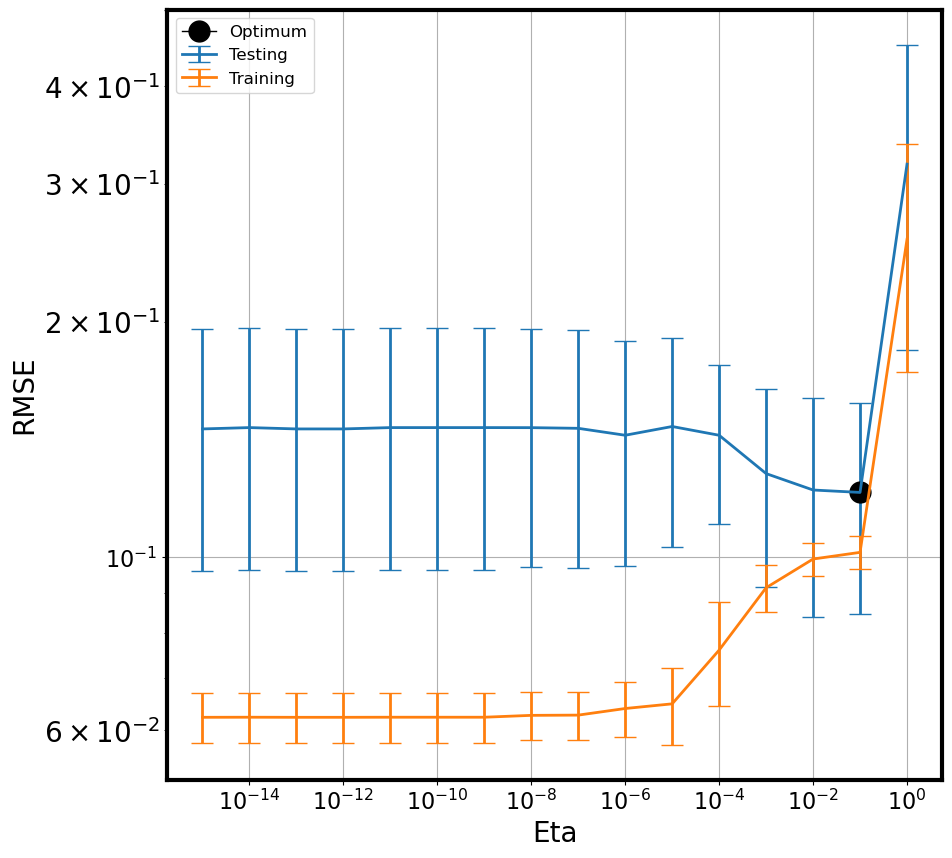

In [28]:
# Perform BCS
pc_final, c_k = pce_tools.UQTkBCS(pc_start, x_train, y_train, niter=niter, mindex_growth='nonconservative', eta=eta, eta_folds=10, eta_growth=True, eta_plot=True)

# Evaluate the PCE
pce_evals = pce_tools.UQTkEvaluatePCE(pc_final, c_k, x_test)

# Calculate error metric
MSE = np.square(np.subtract(y_test, pce_evals)).mean()
NRMSE=math.sqrt(MSE)/np.abs(y_test.mean())
print("The NRMS error between a", ndim, "-dimensional", model, "function and a BCS-based PC surrogate of \
order", nord, "is")
NRMSE

## Regularization weights

Regularization weights control the relative importance of the penalty with respect to the goodness-of-fit. There is one per basis term, and basis terms with larger corresponding weights are more likely to be pruned. Each iteration of BCS updates the weights, based on the latest approximation of coefficients. 

We can specify the initial regularization weights, regparams, in the BCS call. By default, regparams = None, and a vector of initial weights is autopopulated by BCS. However, one may provide a scalar value to use as a weight for all the terms. This makes smaller basis terms more likely to drop out.

Here, we show regparams=1e10.

In [29]:
regparams=1e10
 
pc_start = uqtkpce.PCSet("NISPnoq", nord, ndim, pc_type, pc_alpha, pc_beta)

# Perform BCS
pc_final, c_k = pce_tools.UQTkBCS(pc_start, x_train, y_train, regparams=regparams, verbose=1)

# Evaluate the PCE
pce_evals = pce_tools.UQTkEvaluatePCE(pc_final, c_k, x_test)

# Calculate error metric
MSE = np.square(np.subtract(y_test, pce_evals)).mean()
NRMSE=math.sqrt(MSE)/np.abs(y_test.mean())
print("The NRMS error between a", ndim, "-dimensional", model, "function and a BCS-based PC surrogate of \
order", nord, "is")
NRMSE

============  Split # 1 / 1 ============
==== BCS with multiindex of size 70 ====
BCS has selected 6 basis terms out of 70
Coefficients:
[-0.42051375 -0.42015352 -0.39242555 -0.3595962  -0.35627711  0.08883738]
6  terms retained out of a full basis of size 70
Reestimated sigma2: 1.150e-02

Please note that sigma2 will be returned by default in future versions.
To remain compatible, set input argument return_sigma2 to True and expect
three return arguments: pc_model, coefficients, updated noise variance

The NRMS error between a 4 -dimensional genz_osc function and a BCS-based PC surrogate of order 4 is


0.3524436425793535

## Basis term trimming

To focus on the most important coefficients, we can adjust the basis trimming parameters. npccut is the maximum number of PC coefficients to retain. The default is npccut = None, which retains all coefficients selected by BCS. However, if we wish to limit the number of PC coefficients, we can set npccut to, for example, 10.

In [30]:
# Perform BCS
pc_final, c_k = pce_tools.UQTkBCS(pc_start, x_train, y_train, npccut=10, verbose=1)

# Evaluate the PCE
pce_evals = pce_tools.UQTkEvaluatePCE(pc_final, c_k, x_test)

# Calculate error metric
MSE = np.square(np.subtract(y_test, pce_evals)).mean()
NRMSE=math.sqrt(MSE)/np.abs(y_test.mean())
print("The NRMS error between a", ndim, "-dimensional", model, "function and a BCS-based PC surrogate of \
order", nord, "is")
NRMSE

============  Split # 1 / 1 ============
==== BCS with multiindex of size 70 ====
BCS has selected 17 basis terms out of 70
7 coefficients have been cut because only 10  terms are allowed.
Coefficients:
[-0.36935208 -0.3959887  -0.38575969 -0.41041135 -0.3524368   0.12510656
  0.11470634  0.09683046  0.1290426   0.08523407]
10  terms retained out of a full basis of size 70
Reestimated sigma2: 5.758e-03

Please note that sigma2 will be returned by default in future versions.
To remain compatible, set input argument return_sigma2 to True and expect
three return arguments: pc_model, coefficients, updated noise variance

The NRMS error between a 4 -dimensional genz_osc function and a BCS-based PC surrogate of order 4 is


0.3361300705992165

Another approach to limiting PC coefficients is setting a minimum magnitude for possible coefficient, pcf_thr. The default is pcf_thr = None. Here, we show pcf_thr = 0.1.

In [31]:
# Perform BCS
pc_final, c_k = pce_tools.UQTkBCS(pc_start, x_train, y_train, pcf_thr=0.1, verbose=1)

# Evaluate the PCE
pce_evals = pce_tools.UQTkEvaluatePCE(pc_final, c_k, x_test)

# Calculate error metric
MSE = np.square(np.subtract(y_test, pce_evals)).mean()
NRMSE=math.sqrt(MSE)/np.abs(y_test.mean())
print("The NRMS error between a", ndim, "-dimensional", model, "function and a BCS-based PC surrogate of \
order", nord, "is")
NRMSE

============  Split # 1 / 1 ============
==== BCS with multiindex of size 70 ====
BCS has selected 17 basis terms out of 70
5 coefficients equal to zero or below the magnitude threshold have been cut.
Coefficients:
[-0.37410154 -0.39643237 -0.40111915 -0.39888695 -0.35358233  0.15128684
  0.10741545  0.13063637  0.121388    0.12643134  0.0594203   0.0915976 ]
12  terms retained out of a full basis of size 70
Reestimated sigma2: 5.758e-03

Please note that sigma2 will be returned by default in future versions.
To remain compatible, set input argument return_sigma2 to True and expect
three return arguments: pc_model, coefficients, updated noise variance

The NRMS error between a 4 -dimensional genz_osc function and a BCS-based PC surrogate of order 4 is


0.32363253923407015